### Imputing Missing Values
Ref. https://github.com/srivatsan88/YouTubeLI/blob/master/statistics/Statistical_Thinking_Imputing_Missing_Value.ipynb
https://www.youtube.com/watch?v=JGv9gaCU0i4

In [110]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import base

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
# Dataset derived from https://www.kaggle.com/blastchar/telco-customer-churn
churn_df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/churn_data_st.csv')


In [114]:
churn_df.head()

,customerID,gender,SeniorCitizen,tenure,ServiceCount,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,2,Month-to-month,Yes,29.85,29.85,No
1,5575-GNVDE,Male,0,34,4,One year,No,56.95,1889.50,No
2,3668-QPYBK,Male,0,2,4,Month-to-month,Yes,53.85,108.15,Yes
3,7795-CFOCW,Male,0,45,4,One year,No,42.30,1840.75,No
4,9237-HQITU,Female,0,2,2,Month-to-month,Yes,70.70,151.65,Yes


#### Columns
* customerID - Customer ID
* SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)
* tenure - Number of months the customer has stayed with the company
* ServiceCount - Number of services/product customer has availed
* Contract - The contract term of the customer (Month-to-month, One year, Two year)
* PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
* MonthlyCharges - The amount charged to the customer monthly
* TotalCharges - The total amount charged to the customer
* Churn - Whether the customer churned or not (Yes or No)

In [116]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   tenure            7043 non-null   int64  
 4   ServiceCount      7043 non-null   int64  
 5   Contract          7043 non-null   object 
 6   PaperlessBilling  7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7016 non-null   float64
 9   Churn             7043 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 550.4+ KB


In [118]:
# Number of missing values
churn_df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
tenure               0
ServiceCount         0
Contract             0
PaperlessBilling     0
MonthlyCharges       0
TotalCharges        27
Churn                0
dtype: int64

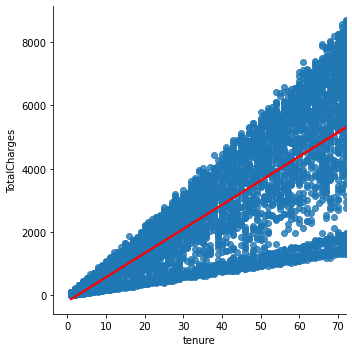

In [120]:
sns.lmplot(x='tenure', y='TotalCharges', data=churn_df, fit_reg=True,  line_kws={'color':'red'});

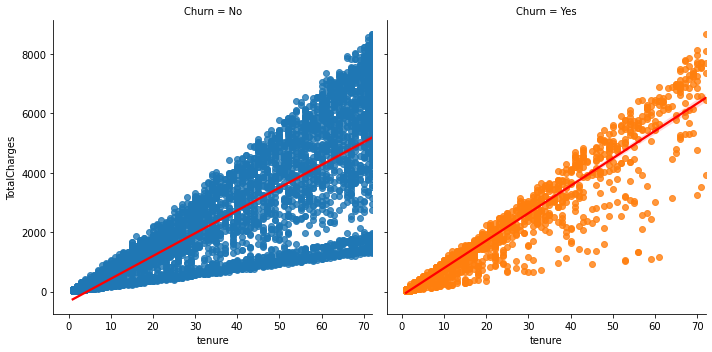

In [122]:
sns.lmplot(x='tenure',y='TotalCharges',data=churn_df,fit_reg=True, col="Churn", hue="Churn", line_kws={'color':'red'});

In [124]:
churn_df[['tenure', 'TotalCharges']].corr()

,tenure,TotalCharges
tenure,1.000000,0.826066
TotalCharges,0.826066,1.000000


In [126]:
mask = (~np.isnan(churn_df['tenure']) & ~np.isnan(churn_df['TotalCharges']))
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(churn_df['tenure'].loc[mask], churn_df['TotalCharges'].loc[mask])

print ("slope     :", slope)
print ("intercept :", intercept)
print ("r_value   :", r_value)
print ("p_value   :", p_value)
print ("std_err   :", std_err)
print("R-squared  :", r_value**2)

slope     : 76.27314553414061
intercept : -189.3739059485506
r_value   : 0.826066024223149
p_value   : 0.0
std_err   : 0.6213330659522552
R-squared  : 0.6823850763758402


In [128]:
churn_df['tenure_charges'] = churn_df['tenure']*churn_df['MonthlyCharges']

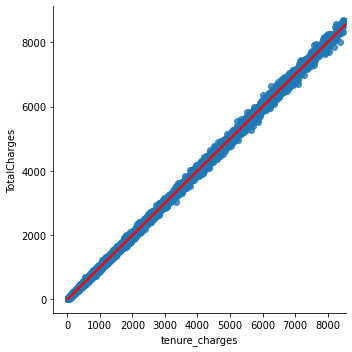

In [130]:
sns.lmplot(x='tenure_charges', y='TotalCharges', data=churn_df, fit_reg=True,  line_kws={'color':'red'});

In [132]:
churn_df[['tenure_charges', 'TotalCharges']].corr()

,tenure_charges,TotalCharges
tenure_charges,1.000000,0.999559
TotalCharges,0.999559,1.000000


In [134]:
mask = (~np.isnan(churn_df['tenure_charges']) & ~np.isnan(churn_df['TotalCharges']))
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(churn_df['tenure_charges'].loc[mask], churn_df['TotalCharges'].loc[mask])

print ("slope     :", slope)
print ("intercept :", intercept)
print ("r_value   :", r_value)
print ("p_value   :", p_value)
print ("std_err   :", std_err)
print("R-squared  :", r_value**2)

slope     : 1.0004479100898105
intercept : -0.8707732448947354
r_value   : 0.9995590946931762
p_value   : 0.0
std_err   : 0.00035484844828776986
R-squared  : 0.9991183837838419


In [136]:
# Negative intercept
churn_df['TotalChargesNew'] = churn_df['TotalCharges']
churn_df.loc[(churn_df['TotalCharges'].isna()) & (churn_df['tenure'] == 0), 'TotalChargesNew'] = churn_df.loc[(churn_df['TotalCharges'].isna()) & (churn_df['tenure'] == 0), 'MonthlyCharges'] 
churn_df.loc[(churn_df['TotalCharges'].isna()) & (churn_df['tenure'] > 0), 'TotalChargesNew'] = intercept + churn_df.loc[(churn_df['TotalCharges'].isna()) & (churn_df['tenure'] > 0), 'tenure_charges']*slope


### Imputation pipeline

In [158]:
class TotalChargesImputer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y=None):
        tenure_charges = X['tenure']*X['MonthlyCharges']
        mask = (~np.isnan(tenure_charges) & ~np.isnan(X['TotalCharges']))
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(tenure_charges.loc[mask], X['TotalCharges'].loc[mask])
        print ("slope     :", slope)
        print ("intercept :", intercept)
        print ("r_value   :", r_value)
        print ("p_value   :", p_value)
        print ("std_err   :", std_err)
        print("R-squared  :", r_value**2)
        return self

    def transform(self, X):
        tenure_charges = churn_df['tenure']*churn_df['MonthlyCharges']
        totalChargesNew = X['TotalCharges'].copy()
        missingAndTenureZero = (X['TotalCharges'].isna() & (X['tenure'] == 0))
        missingAndTenureGreaterThanZero = (X['TotalCharges'].isna() & (X['tenure'] > 0))
        totalChargesNew.loc[missingAndTenureZero] = \
            X.loc[missingAndTenureZero, 'MonthlyCharges'] 
        totalChargesNew.loc[missingAndTenureGreaterThanZero] = \
            intercept + tenure_charges.loc[missingAndTenureGreaterThanZero]*slope
        return totalChargesNew


totalChargesNew = TotalChargesImputer().fit_transform(churn_df)

slope     : 1.0004479100898105
intercept : -0.8707732448947354
r_value   : 0.9995590946931762
p_value   : 0.0
std_err   : 0.00035484844828776986
R-squared  : 0.9991183837838419


In [159]:
churn_df['TotalCharges'].isna().sum(), totalChargesNew.isna().sum()

(27, 0)